In [1]:
%matplotlib inline
import cv2
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy.fft as fft
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
# https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
# https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html

def find_largest_region(arr):
    binary_arr = np.zeros(arr.shape, 'uint8')
    binary_arr[arr != 0] = 1
    label_arr, nb_labels = nd.label(binary_arr)
    sizes = nd.sum(binary_arr, label_arr, range(nb_labels + 1))
    max_label = sizes.argmax()
    label_arr[label_arr != max_label] = 0
    label_arr[label_arr != 0] = 1
    return label_arr


def load_geotiff(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)

    data = ds.GetRasterBand(band).ReadAsArray()
    nodata = ds.GetRasterBand(band).GetNoDataValue()
    mask = data == nodata
    data = np.ma.array(data, mask=mask, fill_value=-9999)
    projection = ds.GetProjection()
    transform = ds.GetGeoTransform()
    ds = None
    return data, transform, projection


def find_centroid(arr):
    largest_region = find_largest_region(arr)
    centroid = nd.center_of_mass(largest_region, largest_region, 1)
    centroid_m = int(np.floor(centroid[0]))
    centroid_n = int(np.floor(centroid[1]))
    return centroid_m, centroid_n

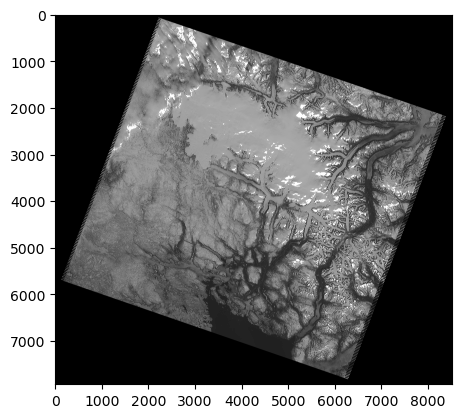

In [6]:
img, trans, proj = load_geotiff('./scenes/LT05_L2SP_018013_20060610_20200901_02_T1_SR_B2.TIF')
img = np.array(img.filled(0))
plt.imshow(img)

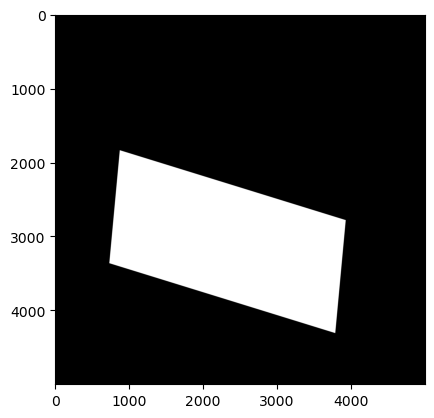

In [5]:
img = np.zeros((5000,5000))
img[1500:3000,1000:4000] = 1
rot = 0.3
affine = [[np.cos(rot), -np.sin(rot),  0],
          [0.3*np.sin(rot),np.cos(rot),0],
          [0,0,1]]

img = nd.affine_transform(img, affine)
img = (img > 0.05).astype(int)
plt.imshow(img)

In [8]:
thresh = find_largest_region(img)
thresh = np.uint8(thresh * 255)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]
M = cv2.moments(cnt)

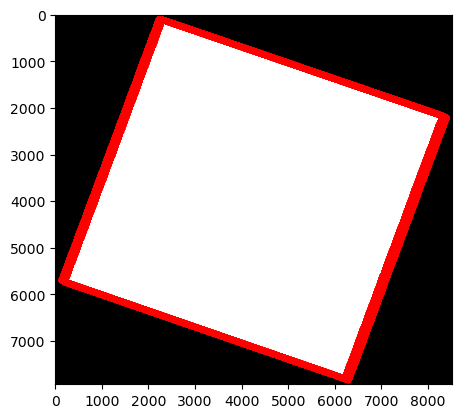

In [9]:
f, ax = plt.subplots(1,1)
ax.imshow(thresh)
ax.scatter(cnt[:,:,0], cnt[:,:,1], color='red', s=10)

((4255.091796875, 3945.076904296875), (6658.47900390625, 6017.2890625), 19.059099197387695)


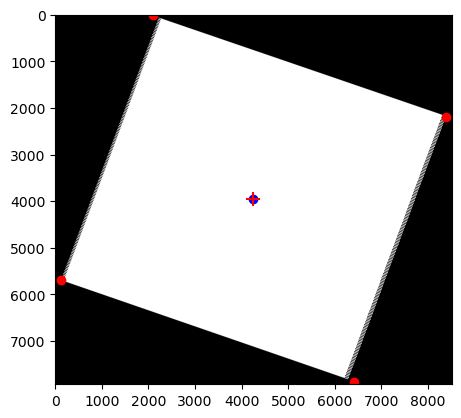

In [10]:
nd_cx, nd_cy = find_centroid(thresh)

cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
f, ax = plt.subplots(1,1)
ax.imshow(thresh)
ax.scatter(box[:,0], box[:,1], color='red')
ax.scatter(nd_cy, nd_cx, color='blue')
ax.scatter(cx, cy, color='red', marker='+', s=100)
print(rect)

In [11]:
np.deg2rad(rect[2])

0.3326440334586239

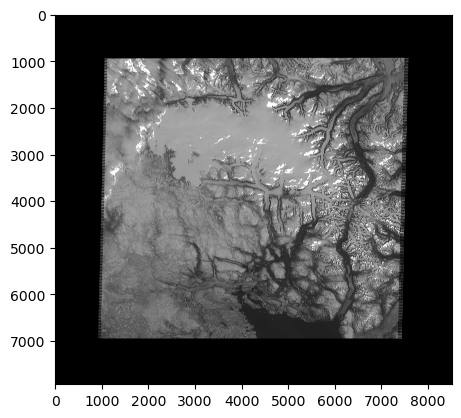

In [12]:
rotated = nd.rotate(img,rect[2],reshape=False)
plt.imshow(rotated)

In [53]:
m, n = img.shape
angle =rect[2]
center_m = int(np.floor(m / 2))
center_n = int(np.floor(n / 2))
filter_base = np.full((m,n), False)
filter_base[center_m - 70:center_m + 70, :] = 1
filter_base[:, center_n - 100:center_n + 100] = 0

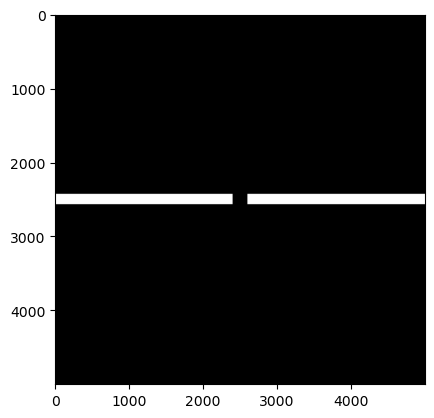

In [54]:
plt.imshow(filter_base)

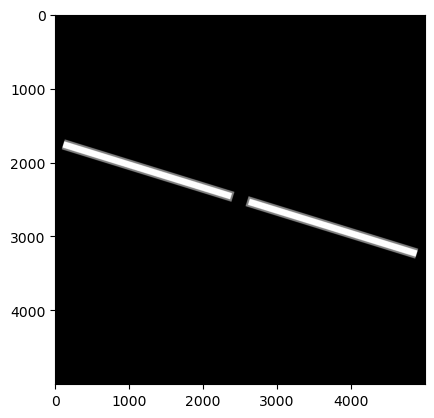

In [55]:
filter_a = nd.rotate(filter_base, -angle, reshape=False)
plt.imshow(filter_a)

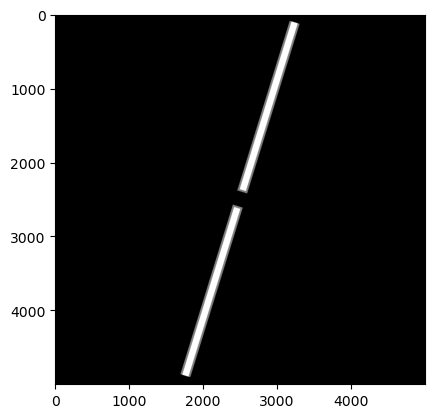

In [56]:
filter_b = nd.rotate(filter_base, 90-angle, reshape=False)
plt.imshow(filter_b)

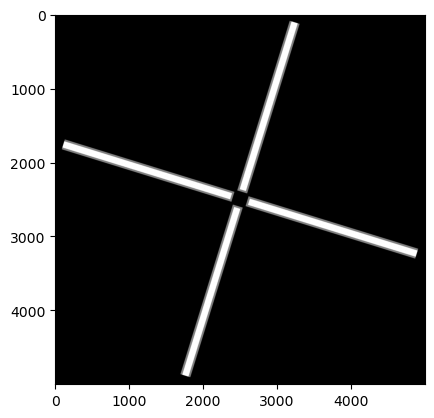

In [59]:
plt.imshow(filter_a+filter_b)

# Comparison